In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

Topic Chosen: Linear Regression

Link to sources:
1. https://hummedia.manchester.ac.uk/institutes/cmist/archive-publications/working-papers/2020/multiple-linear-regression.pdf

2. https://www.mdpi.com/2571-905X/3/2/8

3. https://www.sciencedirect.com/science/article/pii/S1871402120302939


Notes from Sources

- In my case, I am interested in a multivariate model. Linear Regression models allow for the user to use explanatory variables to predict a response variable (y). In other words, this machine learning technique takes dependent variables to predict a dependent variable.
- Source 1 gives an example of a bivariate model. In their model, the program is using exam scores from a given person at age 11 and age 16. They intend to teach the model how to digest the scores from the age 11 exam scores in order to make predictions for what their score will be when they’re 16 by finding trends within the data.
- A bivariate model is incredibly simple to understand and use.
- In multiple linear regression, the equation is the exact same as a simple linear regression model but just has more terms.
- Source 1 offers a number of questions that the authors point out to the reader as important things to ask; Does the model make sense in the real world? Are the assumptions of the linear regression met? Which explanatory variables make the most difference to the outcome variable?
- In my case, my model will be predicting a baseball player’s delta_run_exp based on a number of variables. This will be done by taking advanced data (via Baseball Savant API) from the 2024 season and will include all hitters from last season with a minimum of 100 plate appearances. The inclusion of multiple variables including standard results-based statistics as well as advanced saber-metric variables will allow for us to visualize and understand which players should have performed better (or worse) in the 2024 season.
- Since my model is baseball-based, Source 2 is an experiment that looks to achieve something similar to my goal. In this source, you will find a prediction to find batting averages in Major League Baseball.
- After brainstorming my own ideas as to how I wanted the model to operate, I read the Source 2 paper and adjusted my game plan accordingly. Something that I felt was needed to achieve the best predictions and widen the usage of this model was to include data from 2021-2024. That way, the model will have a higher likelihood of correctly predicting future data.
- Source 2 mentions that player body type, or the physical characteristics of the given player is an important factor. While I agree with this assessment, it’s impossible for me to efficiently gather each height, weight, and wingspan of the players in my 2023 and 2024 data set. The crop of data I am using is much larger because D1 College Baseball simply has more players and teams than the MLB.
- Another thing I noticed about their model is their goal to directly predict one thing. In my case, I’m more focusing on projecting the overall true future value of a given player, which in result will require A. More variables and B. More broadly chosen variables.
- To get a third source that was less relevant to baseball and more applicable to the real world, I chose a source that explained a multivariate linear regression model to predict COVID-19 cases to examine.
- The COVID-19 model was far more simple than the model to predict batting averages but it was informative and gave me a fresh perspective as to how this type of modeling can be impactful outside of sports analytics.


In [ ]:
# Checking the data types and available data columns

df = pd.read_csv("/content/drive/MyDrive/Statcast PBP/statcast_2021.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 727886 entries, 0 to 727885
Data columns (total 94 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   pitch_type                       724982 non-null  object 
 1   game_date                        727886 non-null  object 
 2   release_speed                    724982 non-null  float64
 3   release_pos_x                    724772 non-null  float64
 4   release_pos_z                    724772 non-null  float64
 5   player_name                      727886 non-null  object 
 6   batter                           727886 non-null  int64  
 7   pitcher                          727886 non-null  int64  
 8   events                           186636 non-null  object 
 9   description                      727886 non-null  object 
 10  spin_dir                         0 non-null       float64
 11  spin_rate_deprecated             0 non-null       float64
 12  br

In [ ]:
# Varibles I want to include

# x var.: pfx_z, pfx_x, release_pos_x, release_pos_z, release_speed, release_spin_rate, release_extenstion, pitch_type

# y var. (predicting): delta_run_exp

In [ ]:
# combining and cleaning all 4 csv files from Baseball Savant from years 2021-2024

csv_files = ['/content/drive/MyDrive/Statcast PBP/statcast_2021.csv', '/content/drive/MyDrive/Statcast PBP/statcast_2022.csv', '/content/drive/MyDrive/Statcast PBP/statcast_2023.csv','/content/drive/MyDrive/Statcast PBP/statcast_2024.csv']

columns_to_keep = ['game_date','player_name','pitch_type','release_speed','release_pos_x','release_pos_z', 'pfx_x','pfx_z','release_spin_rate','release_extension','delta_run_exp']

df_list = []

for file in csv_files:
    df = pd.read_csv(file)
    df = df[columns_to_keep]
    df_list.append(df)

df = pd.concat(df_list, ignore_index=True)

In [ ]:
# to account for left handed pitchers, I'll make the release_pos_x and pfx_x variables (both horizontal values) their absolute value

df['release_pos_x'] = df['release_pos_x'].abs()
df['pfx_x'] = df['pfx_x'].abs()

In [ ]:
# for preference, I want pfx_x and pfx_z to be in inches, they are currently in feet

df['pfx_x'] = df['pfx_x'] * 12
df['pfx_z'] = df['pfx_z'] * 12

In [ ]:
# here is what our date frame now looks like

df

,game_date,player_name,pitch_type,release_speed,release_pos_x,release_pos_z,pfx_x,pfx_z,release_spin_rate,release_extension,delta_run_exp
0,2021-11-02,"Smith, Will",FF,93.7,1.39,6.72,6.84,14.52,2112.0,6.1,-0.138
1,2021-11-02,"Smith, Will",FF,92.9,1.38,6.72,10.80,16.08,2206.0,6.3,-0.047
2,2021-11-02,"Smith, Will",FF,93.1,1.35,6.73,9.72,18.24,2216.0,6.2,-0.042
3,2021-11-02,"Smith, Will",FF,94.6,1.31,6.73,10.20,15.24,2263.0,6.3,-0.387
4,2021-11-02,"Smith, Will",FF,93.6,1.31,6.80,10.80,17.16,2239.0,6.2,0.120
...,...,...,...,...,...,...,...,...,...,...,...
2512975,2024-03-28,"Eovaldi, Nathan",CU,78.0,2.24,5.69,7.68,-9.12,1962.0,6.6,-0.014
2512976,2024-03-28,"Eovaldi, Nathan",FF,96.7,2.41,5.34,12.84,14.28,2259.0,6.7,-0.159
2512977,2024-03-28,"Eovaldi, Nathan",CU,78.1,2.27,5.62,6.96,-12.36,1995.0,6.6,-0.029
2512978,2024-03-28,"Eovaldi, Nathan",FF,97.0,2.40,5.36,16.44,11.04,2259.0,6.9,0.025


In [ ]:
# here are some median numbers to keep in mind, these are all release characteristics that are not (rather, should not) be varied from pitch_type to pitch_type

print(df['release_pos_x'].median())
print(df['release_pos_z'].median())
print(df['release_extension'].median())

1.85
5.85
6.4


In [ ]:
# here is the median, floor, and ceiling of our output variable, delta_run_exp

print(df['delta_run_exp'].median())
print(df['delta_run_exp'].min())
print(df['delta_run_exp'].max())

-0.018
-1.537
3.65


In [ ]:
#the goal of this model is to predict the delta_run_exp of a pitch given the variables that I believe to be the most important to a pitch's success

#we will predict the delta_run_exp of every pitch in the df and compare it to the actual y variable to see how our model performs

#I will also test this model on college baseball data and minor league baseball data, as well as use it to predict 'future' success in MLB pitchers

In [ ]:
#another issue I ran into was the fact that pitch_type is a str value, meaning it cannot work in the model

#pitch type is dire to the success and accuracy of the model so i will apply numeric values to each of the pitch types in order to separate them but keep them included

df['pitch_type'].unique()

array(['FF', 'SL', 'CU', 'CH', 'FS', 'SI', 'ST', 'KC', 'FC', 'SV', 'PO',
       'CS', nan, 'FA', 'EP', 'KN', 'SC', 'FO'], dtype=object)

In [ ]:
pitch_type_mapping = {
    'FO': 1,
    'SC': 2,
    'KN': 3,
    'EP': 4,
    'FA': 5,
    'CS': 6,
    'PO': 7,
    'SV': 8,
    'FC': 9,
    'KC': 10,
    'ST': 11,
    'SI': 12,
    'FS': 13,
    'CH': 14,
    'CU': 15,
    'SL': 16,
    'FF': 17
}

pitch_type_mapping[float('nan')] = 0

df['pitch_type'] = df['pitch_type'].map(pitch_type_mapping)

In [ ]:
# check the pitch_type column

# assigning numeric values to the pitch types could cause issues down the line by making the model biased to a higher valued pitch type

# ex. FF (17) is much greater than say a FC (9) by their numeric values

# given the fact that we are working with over a million lines of data, I feel like this model can be sufficient even with this method

df['pitch_type']

,pitch_type
0,17
1,17
2,17
3,17
4,17
...,...
2512975,15
2512976,17
2512977,15
2512978,17


In [ ]:
# check df for any NaN values and remove them (there is plenty of data to the point where removing lines rather than subbing them out makes sense)

# another method could be to, instead of dropping NaN values, replace them with the grouped pitcher (and pitch type) median of the missing value

nan_counts = df.isna().sum()
print(nan_counts)

game_date                0
player_name              0
pitch_type               0
release_speed        14503
release_pos_x        14713
release_pos_z        14713
pfx_x                14521
pfx_z                14510
release_spin_rate    25465
release_extension    18534
delta_run_exp        34458
dtype: int64


In [ ]:
# remove the rows with any NaN values

df = df.dropna()

In [ ]:
# check df again

df

,game_date,player_name,pitch_type,release_speed,release_pos_x,release_pos_z,pfx_x,pfx_z,release_spin_rate,release_extension,delta_run_exp
0,2021-11-02,"Smith, Will",17,93.7,1.39,6.72,6.84,14.52,2112.0,6.1,-0.138
1,2021-11-02,"Smith, Will",17,92.9,1.38,6.72,10.80,16.08,2206.0,6.3,-0.047
2,2021-11-02,"Smith, Will",17,93.1,1.35,6.73,9.72,18.24,2216.0,6.2,-0.042
3,2021-11-02,"Smith, Will",17,94.6,1.31,6.73,10.20,15.24,2263.0,6.3,-0.387
4,2021-11-02,"Smith, Will",17,93.6,1.31,6.80,10.80,17.16,2239.0,6.2,0.120
...,...,...,...,...,...,...,...,...,...,...,...
2512975,2024-03-28,"Eovaldi, Nathan",15,78.0,2.24,5.69,7.68,-9.12,1962.0,6.6,-0.014
2512976,2024-03-28,"Eovaldi, Nathan",17,96.7,2.41,5.34,12.84,14.28,2259.0,6.7,-0.159
2512977,2024-03-28,"Eovaldi, Nathan",15,78.1,2.27,5.62,6.96,-12.36,1995.0,6.6,-0.029
2512978,2024-03-28,"Eovaldi, Nathan",17,97.0,2.40,5.36,16.44,11.04,2259.0,6.9,0.025


In [ ]:
nan_counts = df.isna().sum()
print(nan_counts)

game_date            0
player_name          0
pitch_type           0
release_speed        0
release_pos_x        0
release_pos_z        0
pfx_x                0
pfx_z                0
release_spin_rate    0
release_extension    0
delta_run_exp        0
dtype: int64


In [ ]:
reg = linear_model.LinearRegression()
reg.fit(df[['release_pos_x', 'release_pos_z', 'release_speed', 'release_spin_rate', 'release_extension', 'pfx_x', 'pfx_z','pitch_type']], df['delta_run_exp'])

LinearRegression()

In [ ]:
reg.coef_

array([ 1.64957345e-04, -6.13322558e-05, -4.11683281e-04, -6.70544446e-06,
       -2.91384337e-03, -1.43188792e-04,  1.63008864e-04,  1.04072301e-04])

In [ ]:
reg.intercept_

0.06888876374349673

In [ ]:


reg.predict([[1.9,5.8,70.3,2318,7.0,5.8,17.7,17]])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([0.00778899])

In [ ]:
coef = reg.coef_

print(coef)

[ 1.64957345e-04 -6.13322558e-05 -4.11683281e-04 -6.70544446e-06
 -2.91384337e-03 -1.43188792e-04  1.63008864e-04  1.04072301e-04]


In [ ]:
# now, i want to add a new column to the df that will have the predicted delta_run_exp using the model i just built

#that way, we can start to see which pitchers have the best delta_run_exp, sort by year, month, etc.

#Then, I can test the stickiness of the model to other pitcher predictors such as ERA, FIP, SwStr%, etc.

X = df[['release_pos_x', 'release_pos_z', 'release_speed', 'release_spin_rate',
        'release_extension', 'pfx_x', 'pfx_z', 'pitch_type']]

df['stuff_pred_run_exp'] = reg.predict(X)

df

<ipython-input-21-c5630cec4f30>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['stuff_pred_run_exp'] = reg.predict(X)


,game_date,player_name,pitch_type,release_speed,release_pos_x,release_pos_z,pfx_x,pfx_z,release_spin_rate,release_extension,delta_run_exp,stuff_pred_run_exp
0,2021-11-02,"Smith, Will",17,93.7,1.39,6.72,6.84,14.52,2112.0,6.1,-0.138,0.001352
1,2021-11-02,"Smith, Will",17,92.9,1.38,6.72,10.80,16.08,2206.0,6.3,-0.047,0.000153
2,2021-11-02,"Smith, Will",17,93.1,1.35,6.73,9.72,18.24,2216.0,6.2,-0.042,0.000797
3,2021-11-02,"Smith, Will",17,94.6,1.31,6.73,10.20,15.24,2263.0,6.3,-0.387,-0.000992
4,2021-11-02,"Smith, Will",17,93.6,1.31,6.80,10.80,17.16,2239.0,6.2,0.120,0.000095
...,...,...,...,...,...,...,...,...,...,...,...,...
2512975,2024-03-28,"Eovaldi, Nathan",15,78.0,2.24,5.69,7.68,-9.12,1962.0,6.6,-0.014,0.003385
2512976,2024-03-28,"Eovaldi, Nathan",17,96.7,2.41,5.34,12.84,14.28,2259.0,6.7,-0.159,-0.003263
2512977,2024-03-28,"Eovaldi, Nathan",15,78.1,2.27,5.62,6.96,-12.36,1995.0,6.6,-0.029,0.002707
2512978,2024-03-28,"Eovaldi, Nathan",17,97.0,2.40,5.36,16.44,11.04,2259.0,6.9,0.025,-0.005016


In [ ]:
# here is a breakdown of the models percentiles for new delta_run_exp

df['stuff_pred_run_exp'].quantile([0,0.25,0.5,0.75,1])

,stuff_pred_run_exp
0.00,-0.016767
0.25,-0.002170
0.50,-0.000310
0.75,0.001806
1.00,0.045895


In [ ]:
# now we can take a look at the 'best' pitch types in our df (knowing that for pitchers, a lower delta_run_exp is better)

grouped_df = df.groupby(['player_name', 'pitch_type'])['stuff_pred_run_exp',].mean().reset_index()
grouped_df

,player_name,pitch_type,stuff_pred_run_exp
0,"Abad, Fernando",9,0.003050
1,"Abad, Fernando",10,0.002628
2,"Abad, Fernando",12,0.000586
3,"Abad, Fernando",14,0.010681
4,"Abad, Fernando",17,0.002209
...,...,...,...
6277,"de Geus, Brett",17,0.001532
6278,"deGrom, Jacob",14,0.000334
6279,"deGrom, Jacob",15,-0.002762
6280,"deGrom, Jacob",16,-0.004284


In [ ]:
sorted_df = grouped_df.sort_values(by='stuff_pred_run_exp', ascending=True)
sorted_df.head(50)

,player_name,pitch_type,stuff_pred_run_exp
1456,"Díaz, Edwin",12,-0.009285
1984,"Glasnow, Tyler",12,-0.007993
3418,"May, Dustin",15,-0.007947
3306,"Maples, Dillon",15,-0.007535
963,"Chapman, Aroldis",12,-0.007496
4343,"Pressly, Ryan",15,-0.007153
5314,"Stratton, Chris",11,-0.007139
634,"Brash, Matt",10,-0.007051
3744,"Montes de Oca, Bryce",12,-0.007029
2321,"Henley, Blair",15,-0.007028


In [ ]:
# i want to sort the pitchers by pitch type and year to run tests more efficiently

df['year'] = pd.to_datetime(df['game_date']).dt.year

<ipython-input-25-b137e879ec9f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = pd.to_datetime(df['game_date']).dt.year


In [ ]:
grouped_df = df.groupby(['player_name', 'pitch_type', 'year'])['stuff_pred_run_exp'].mean().reset_index()
grouped_df

,player_name,pitch_type,year,stuff_pred_run_exp
0,"Abad, Fernando",9,2021,0.003050
1,"Abad, Fernando",10,2021,0.002510
2,"Abad, Fernando",10,2023,0.003028
3,"Abad, Fernando",12,2021,0.000635
4,"Abad, Fernando",12,2023,0.000495
...,...,...,...,...
13503,"deGrom, Jacob",16,2022,-0.003846
13504,"deGrom, Jacob",16,2023,-0.004419
13505,"deGrom, Jacob",17,2021,-0.005367
13506,"deGrom, Jacob",17,2022,-0.005156


In [ ]:
sorted_df = grouped_df.sort_values(by='stuff_pred_run_exp', ascending=True)
sorted_df.head(50)

,player_name,pitch_type,year,stuff_pred_run_exp
3191,"Díaz, Edwin",12,2021,-0.009285
4377,"Glasnow, Tyler",15,2021,-0.008590
7567,"May, Dustin",15,2022,-0.008466
7566,"May, Dustin",15,2021,-0.008376
4374,"Glasnow, Tyler",12,2024,-0.008161
2093,"Chapman, Aroldis",12,2023,-0.007788
5769,"Jax, Griffin",15,2024,-0.007738
5760,"Jax, Griffin",11,2024,-0.007734
2092,"Chapman, Aroldis",12,2022,-0.007720
2091,"Chapman, Aroldis",12,2021,-0.007622


In [ ]:
# in order to separate out players with a lack of sufficient data, i'm going to add a pitch total column


grouped_df['pitch_count'] = df.groupby(['player_name', 'pitch_type', 'year']).size().values


In [ ]:
qual_df = grouped_df[grouped_df['pitch_count'] > 25]
qual_df

,player_name,pitch_type,year,stuff_pred_run_exp,pitch_count
1,"Abad, Fernando",10,2021,0.002510,78
3,"Abad, Fernando",12,2021,0.000635,139
4,"Abad, Fernando",12,2023,0.000495,75
5,"Abad, Fernando",14,2021,0.011716,47
9,"Abbott, Andrew",11,2023,-0.002302,311
...,...,...,...,...,...
13503,"deGrom, Jacob",16,2022,-0.003846,407
13504,"deGrom, Jacob",16,2023,-0.004419,167
13505,"deGrom, Jacob",17,2021,-0.005367,704
13506,"deGrom, Jacob",17,2022,-0.005156,497


In [ ]:
grouped_df.to_csv('Stuff+.csv', index=False)

In [ ]:
# now, I can mirror other similar pitch models by making the predicted run_exp easier to read

# i will do this by making the mean predicted run_exp 100 and each number in either direction will be 1% better or worse, 99 would be 1% worse, 101 would be 1% better than the mean

# this score formatting will be titled cStuff+


filtered_df = grouped_df[grouped_df['pitch_count'] >= 25]


mean_stuff_pred_run_exp = filtered_df['stuff_pred_run_exp'].mean()


filtered_df['cStuff+'] = 100 + (mean_stuff_pred_run_exp - filtered_df['stuff_pred_run_exp']) / mean_stuff_pred_run_exp * 100


print(filtered_df[['player_name', 'pitch_type', 'year', 'stuff_pred_run_exp', 'cStuff+', 'pitch_count']].head())



      player_name  pitch_type  year  stuff_pred_run_exp      cStuff+  \
1  Abad, Fernando          10  2021            0.002510  -340.357662   
3  Abad, Fernando          12  2021            0.000635    63.394585   
4  Abad, Fernando          12  2023            0.000495    93.554384   
5  Abad, Fernando          14  2021            0.011716 -2321.822730   
9  Abbott, Andrew          11  2023           -0.002302   695.476120   

   pitch_count  
1           78  
3          139  
4           75  
5           47  
9          311  


<ipython-input-32-7322bda9a31a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cStuff+'] = 100 + (mean_stuff_pred_run_exp - filtered_df['stuff_pred_run_exp']) / mean_stuff_pred_run_exp * 100


In [ ]:
# There is way too much fluctuation in the cStuff+ grades

# I researched how I can fix this and standardizing the data seems to be the best option

# I will do this by taking each predicted run_exp value, subtracting the mean, and dividing by the standard deviation

In [ ]:

filtered_df = grouped_df[grouped_df['pitch_count'] >= 25]


mean_stuff_pred_run_exp = filtered_df['stuff_pred_run_exp'].mean()
std_stuff_pred_run_exp = filtered_df['stuff_pred_run_exp'].std()


filtered_df['standardized_stuff_pred_run_exp'] = (filtered_df['stuff_pred_run_exp'] - mean_stuff_pred_run_exp) / std_stuff_pred_run_exp


filtered_df['cStuff+'] = 100 - filtered_df['standardized_stuff_pred_run_exp'] * 10  # from research, multiplying by 10 to scale down


print(filtered_df[['player_name', 'pitch_type', 'year', 'stuff_pred_run_exp', 'cStuff+', 'pitch_count']].head())


      player_name  pitch_type  year  stuff_pred_run_exp     cStuff+  \
1  Abad, Fernando          10  2021            0.002510   94.125690   
3  Abad, Fernando          12  2021            0.000635   99.511689   
4  Abad, Fernando          12  2023            0.000495   99.914016   
5  Abad, Fernando          14  2021            0.011716   67.693220   
9  Abbott, Andrew          11  2023           -0.002302  107.943569   

   pitch_count  
1           78  
3          139  
4           75  
5           47  
9          311  


<ipython-input-33-b9c820643955>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['standardized_stuff_pred_run_exp'] = (filtered_df['stuff_pred_run_exp'] - mean_stuff_pred_run_exp) / std_stuff_pred_run_exp
<ipython-input-33-b9c820643955>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cStuff+'] = 100 - filtered_df['standardized_stuff_pred_run_exp'] * 10  # from research, multiplying by 10 to scale down


In [ ]:
filtered_df.to_csv('cStuff+.csv', index=False)

In [ ]:
# now, adjusting the model slightly to yield more accurate results and making a new csv that includes grouped data with metrics as well as our predicted scores

# this will include the cStuff+ grade in it's raw and adjusted form
df['pitch_count'] = df.groupby(['player_name', 'pitch_type', 'year'])['stuff_pred_run_exp'].transform('size')


filtered_df = df[df['pitch_count'] >= 25]


mean_stuff_pred_run_exp = filtered_df['stuff_pred_run_exp'].mean()
std_stuff_pred_run_exp = filtered_df['stuff_pred_run_exp'].std()


filtered_df.loc[:, 'standardized_stuff_pred_run_exp'] = (filtered_df['stuff_pred_run_exp'] - mean_stuff_pred_run_exp) / std_stuff_pred_run_exp


filtered_df.loc[:, 'cStuff+'] = 100 - filtered_df['standardized_stuff_pred_run_exp'] * 10


agg_df = filtered_df.groupby(['player_name', 'pitch_type', 'year']).agg({
    'cStuff+': 'mean',
    'release_pos_x': 'mean',
    'release_pos_z': 'mean',
    'release_speed': 'mean',
    'release_spin_rate': 'mean',
    'release_extension': 'mean',
    'pfx_x': 'mean',
    'pfx_z': 'mean',
    'stuff_pred_run_exp': 'mean',
    'delta_run_exp': 'mean',
    'standardized_stuff_pred_run_exp':'mean',
    'pitch_count': 'first'
}).reset_index()


reverse_pitch_type_mapping = {v: k for k, v in pitch_type_mapping.items()}


agg_df['pitch_type'] = agg_df['pitch_type'].map(reverse_pitch_type_mapping)


print(agg_df.head())


<ipython-input-37-91c680248b08>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pitch_count'] = df.groupby(['player_name', 'pitch_type', 'year'])['stuff_pred_run_exp'].transform('size')
<ipython-input-37-91c680248b08>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.loc[:, 'standardized_stuff_pred_run_exp'] = (filtered_df['stuff_pred_run_exp'] - mean_stuff_pred_run_exp) / std_stuff_pred_run_exp
<ipython-input-37-91c680248b08>:15: SettingWithCopyWarning: 
A value is trying to be set on a co

      player_name pitch_type  year     cStuff+  release_pos_x  release_pos_z  \
0  Abad, Fernando         KC  2021   92.182548       0.734872       6.259744   
1  Abad, Fernando         SI  2021   97.947496       0.559353       6.294676   
2  Abad, Fernando         SI  2023   98.378131       0.161467       6.272267   
3  Abad, Fernando         CH  2021   63.890340       0.715957       6.423404   
4  Abbott, Andrew         ST  2023  106.972627       1.703119       5.729260   

   release_speed  release_spin_rate  release_extension      pfx_x      pfx_z  \
0      76.408974        2501.858974           5.625641   7.230769  -9.180000   
1      92.415827        2144.841727           5.830216  13.221583  12.885755   
2      92.365333        2114.946667           5.881333  12.696000  11.515200   
3      75.253191        1643.595745           5.880851  10.733617  14.234043   
4      82.948553        2645.073955           6.755949  11.724502   6.039743   

   stuff_pred_run_exp  delta_run_exp  

In [ ]:
agg_df.to_csv('cStuff+.csv', index=False)

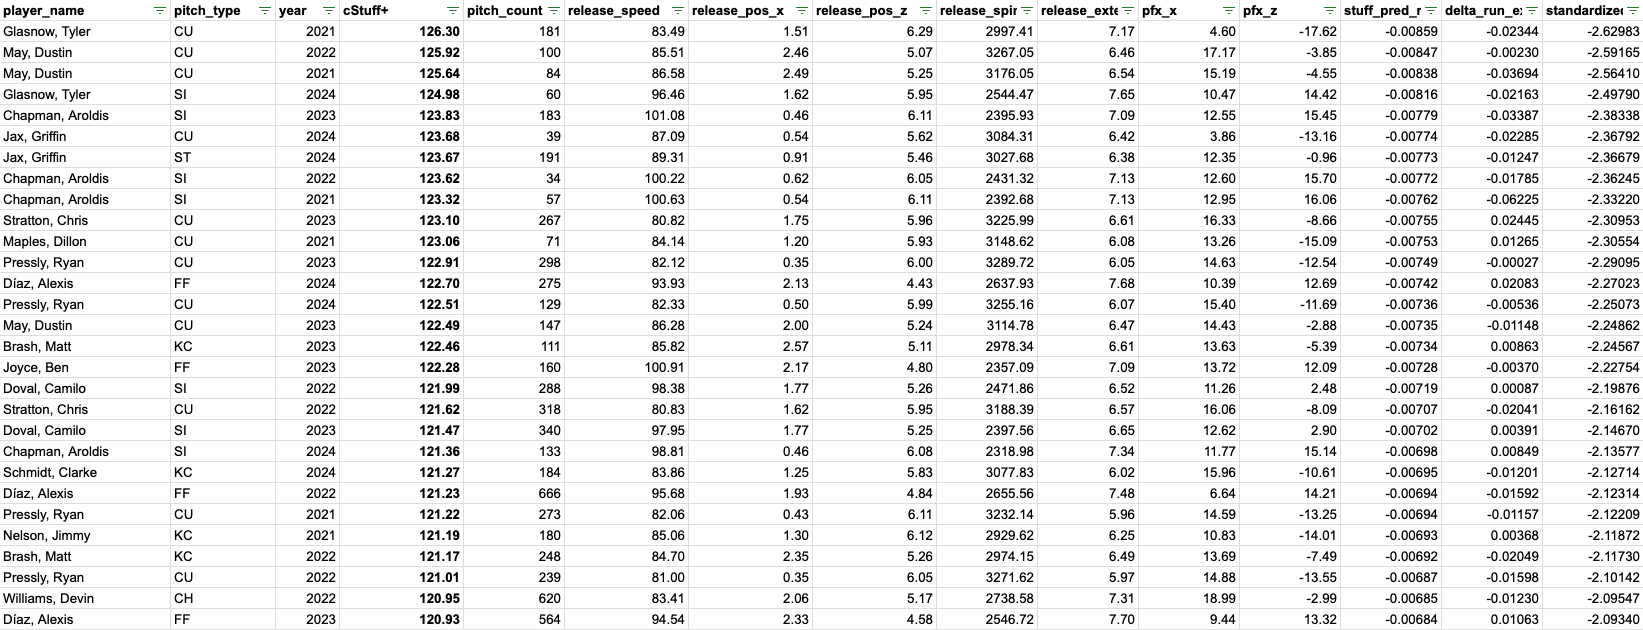

In [ ]:
#Now, we have this spreadsheet where we can filter the data by any stat, the predicted run_exp scores, standardized run_exp, and finally, cStuff+

In [ ]:
import pandas as pd

# Load the CSV data
df = pd.read_csv('/content/drive/MyDrive/cStuff+ (4).csv')

# Group by player_name and year to calculate the weighted average of cStuff+
def weighted_average(group):
    # Weighted average = sum(cStuff+ * pitch_count) / sum(pitch_count)
    weighted_avg = (group['cStuff+'] * group['pitch_count']).sum() / group['pitch_count'].sum()
    return pd.Series({'weighted_cStuff+': weighted_avg})

# Apply the weighted average function, grouped by player_name and year
weighted_df = df.groupby(['player_name', 'year']).apply(weighted_average).reset_index()

# Display or save the result to a new CSV
print(weighted_df)

# Optionally, save to CSV
weighted_df.to_csv('weighted_cStuff_plus_by_year.csv', index=False)


            player_name  year  weighted_cStuff+
0        Abad, Fernando  2021         90.181010
1        Abad, Fernando  2023         98.378131
2        Abbott, Andrew  2023        102.941098
3        Abbott, Andrew  2024        102.407974
4          Abbott, Cory  2021         97.864604
...                 ...   ...               ...
2972  Zuñiga, Guillermo  2024        105.088311
2973     de Geus, Brett  2021         98.073149
2974      deGrom, Jacob  2021        114.244612
2975      deGrom, Jacob  2022        112.195060
2976      deGrom, Jacob  2023        113.834148

[2977 rows x 3 columns]


In [ ]:
sec_df = pd.read_csv('/content/drive/MyDrive/SEC_Pitching_pbp.csv')

<ipython-input-4-5b9d64c68187>:1: DtypeWarning: Columns (27,93) have mixed types. Specify dtype option on import or set low_memory=False.
  sec_df = pd.read_csv('/content/drive/MyDrive/SEC_Pitching_pbp.csv')


In [ ]:
sec_df

,PitchNo,Date,Time,PAofInning,PitchofPA,Pitcher,PitcherId,PitcherThrows,PitcherTeam,Batter,...,ThrowTrajectoryZc1,ThrowTrajectoryZc2,PitchReleaseConfidence,PitchLocationConfidence,PitchMovementConfidence,HitLaunchConfidence,HitLandingConfidence,CatcherThrowCatchConfidence,CatcherThrowReleaseConfidence,CatcherThrowLocationConfidence
0,1,2024-02-18,13:03:21,1,1,"Coleman, Javen",6.944950e+05,Left,LSU_TIG,"Swaim, Ty",...,NaN,NaN,High,High,High,NaN,NaN,NaN,NaN,NaN
1,2,2024-02-18,13:03:33,1,2,"Coleman, Javen",6.944950e+05,Left,LSU_TIG,"Swaim, Ty",...,NaN,NaN,High,High,High,High,High,NaN,NaN,NaN
2,3,2024-02-18,13:04:06,2,1,"Coleman, Javen",6.944950e+05,Left,LSU_TIG,"Jenkins, Cole",...,NaN,NaN,High,High,High,NaN,NaN,NaN,NaN,NaN
3,4,2024-02-18,13:04:20,2,2,"Coleman, Javen",6.944950e+05,Left,LSU_TIG,"Jenkins, Cole",...,NaN,NaN,High,High,High,NaN,NaN,NaN,NaN,NaN
4,5,2024-02-18,13:04:32,2,3,"Coleman, Javen",6.944950e+05,Left,LSU_TIG,"Jenkins, Cole",...,NaN,NaN,High,High,High,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122686,312,2024-05-31,20:58:09,2,1,"Campbell, Carter",1.000052e+09,Left,OKL_SOO,"Davis, Martell",...,NaN,NaN,High,High,High,NaN,NaN,NaN,NaN,NaN
122687,313,2024-05-31,20:58:20,2,2,"Campbell, Carter",1.000052e+09,Left,OKL_SOO,"Davis, Martell",...,NaN,NaN,High,High,High,NaN,NaN,NaN,NaN,NaN
122688,314,2024-05-31,20:58:33,2,3,"Campbell, Carter",1.000052e+09,Left,OKL_SOO,"Davis, Martell",...,NaN,NaN,High,High,High,NaN,NaN,NaN,NaN,NaN
122689,315,2024-05-31,20:59:09,3,1,"Campbell, Carter",1.000052e+09,Left,OKL_SOO,"Herring, David",...,NaN,NaN,High,High,High,High,Low,NaN,NaN,NaN
